___
<b> Project#3 WeRateDogs </b> for Udacity's Data Analyst Nanodegree

Made by: Ashley Adrias
___

# Import Packages 

## Packages

In [113]:
import pandas as pd # Dataframe manipulation
import numpy as np # Mathematical Operations

import tweepy # Access Twitter API package
import json # JSON manipulation
import os # Directory manipulation
from tqdm import * # Progress tracker bar for tweet import

import requests # Request to server to download files
import sqlalchemy # Export clean data to sql database
import pickle # Serializa error handling

## Step#1 Import Data

### Import WeRateDog Tweet Archive from twitter-archive-enhanced.csv

In [114]:
# Import Manually Downloaded Data
df_twitter_arch = pd.read_csv("twitter-archive-enhanced.csv")

df_twitter_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Import Image Prediction from Udacity Server

In [115]:
# Import Image Prediction file from Udacity Server using request
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# Save the file to image-predictions.tsv
with open('image-predictions.tsv', "wb") as file: file.write(response.content)
    
# Input data from image-preductions.tsv into a dataframe, tsv is 't' seperated value
df_breeds_pred = pd.read_csv('image-predictions.tsv', sep="\t")

# View the 1st 5 lines
df_breeds_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Import Tweets from Twitter via Tweepy and Twitter API

In [116]:
# Import Twitter API details into dataframe
df_api = pd.read_csv("twitter-api.csv")

# Assign API auth details to its respective variable
consumer_key = df_api.iloc[0,1]
consumer_secret = df_api.iloc[1,1]
access_token = df_api.iloc[2,1]
access_secret = df_api.iloc[3,1]

# Using the auth details setup connection
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# From the WeRateDogs tweets, create a list of tweet_ids, which will be used to gather more tweet info from Twitter
tweet_ids = df_twitter_arch["tweet_id"].astype(list)

In [117]:
# Write the Tween JSON to File called tweet_json.txt. Unfound ids are inputted into failed_ids[]
failed_ids=[]

if not os.path.exists('tweet_json.txt'):
    with open('tweet_json.txt', 'a', encoding='UTF-8') as file:
        for tweet_id in tqdm(tweet_ids):
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')._json
                json.dump(tweet, file)
                file.write('\n')
            except:
                print(tweet_id, "encountered an error, writing to memory.")
                failed_ids.append(tweet_ids)

In [118]:
# Let's pickle the error for later investigation
pickle.dump(failed_ids, open("failed_ids.pkl", "wb"))

#print(failed_ids)


In [119]:
# Insert the JSON file into a dataframe called df_api by each line

# We first need to insert each line in the JSON file into a list. Each item on the list is from 1 tweet
tweets_data = []
with open('tweet_json.txt') as file:
    for line in file:
        try:
            tweet = json.loads(line) # load tweet
            tweets_data.append(tweet) # Append to list
        except:
            continue
            
#Convert tweets_data list into df_api            
df_api = pd.DataFrame(tweets_data, columns=list(tweets_data[0].keys()))

df_api.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,8544,38641,False,False,False,False,en
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,6285,33118,False,False,False,False,en
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,4162,24932,False,False,False,False,en
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,8664,42028,False,False,False,False,en
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,9423,40183,False,False,False,False,en


In [120]:
# Lets see what kind columns we have from twitter 
df_api.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang'],
      dtype='object')

In [121]:
# We don't need them all, so lets trim down df_api to the necessary columns
df_api_trim = df_api[['id', 'retweet_count', 'favorite_count']]

df_api_trim.head()

,id,retweet_count,favorite_count
0,892420643555336193,8544,38641
1,892177421306343426,6285,33118
2,891815181378084864,4162,24932
3,891689557279858688,8664,42028
4,891327558926688256,9423,40183


In [122]:
# Save Dataframe for Visual Assessment
df_api_trim.to_csv("tweet_json.csv")

# Copy Dataframes for Cleaning
df_twitter_arch_clean = df_twitter_arch.copy()
df_breeds_pred_clean = df_breeds_pred.copy()
df_api_trim_clean = df_api_trim.copy()

# Step#2 Assess

### df_twitter_arch

In [123]:
# Check Data Types of Each Dataframe
df_twitter_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [124]:
df_twitter_arch_clean.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


Quality Issues: 
* Some of the columns have missing values:
    <br> in_reply_to_status_id: 78 non-null float64
    <br> in_reply_to_user_id: 78 non-null float64
    <br> retweeted_status_id: 181 non-null float64
    <br> retweeted_status_user_id: 181 non-null float64
    <br> retweeted_status_timestamp: 181 non-null object
    <br> expanded_urls: 2297 non-null object 
* tweet_id needs to converted to a categorical variable
* the numerator is not always less than the demoninator


Tidiness Issues:
* We should combine the doggo, floofer, pupper, and puppo together. They both represent some sort of dog theme




___

### df_breeds_pred

In [125]:
df_breeds_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [126]:
df_breeds_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Quality Issues:
* We can remove img_num, doesn't provide any valuable information
* There are no empty values

Let's see how good the breed predictors are...

In [127]:
# We are checking how good the 3 predictors are a guessing whether the photo is of a dog or not
df_breeds_pred[(df_breeds_pred["p1_dog"] == False) &
         (df_breeds_pred["p2_dog"] == False) &
         (df_breeds_pred["p3_dog"] == False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


324/2075 tweets were unanimously predicted as not dogs

In [128]:
# Lets see how the 1st predictor tested out
df_breeds_pred[(df_breeds_pred["p1_dog"] == True)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
11,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,Gordon_setter,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True


1532/2075 were dogs from the 1st predictor

In [129]:
# Checking selection when the 2nd or 3rd probabilities are dogs
df_breeds_pred[((df_breeds_pred["p1_dog"] == False) &
         ((df_breeds_pred["p2_dog"] == True) |
         (df_breeds_pred["p3_dog"] == True)))]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,0.278407,True,groenendael,0.102643,True
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
52,666996132027977728,https://pbs.twimg.com/media/CUGlb6iUwAITEbW.jpg,1,hay,0.507637,False,Rottweiler,0.062490,True,water_buffalo,0.048425,False
87,667524857454854144,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,1,hare,0.447893,False,dhole,0.092435,False,Chesapeake_Bay_retriever,0.088122,True
95,667550904950915073,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,1,web_site,0.999335,False,vizsla,0.000081,True,collie,0.000069,True
103,667806454573760512,https://pbs.twimg.com/media/CUSGbXeVAAAgztZ.jpg,1,toyshop,0.253089,False,Chihuahua,0.187155,True,Brabancon_griffon,0.112799,True
108,667878741721415682,https://pbs.twimg.com/media/CUTILFiWcAE8Rle.jpg,1,seat_belt,0.200373,False,miniature_pinscher,0.106003,True,schipperke,0.104733,True
113,667915453470232577,https://pbs.twimg.com/media/CUTpj-GWcAATc6A.jpg,1,leatherback_turtle,0.452517,False,boxer,0.196655,True,terrapin,0.160983,False


219/2075 tweets were the shown to be dogs by the predictor 2 & 3, but not 1
___
### df_api_trim

In [130]:
df_api_trim_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 3 columns):
id                2344 non-null int64
retweet_count     2344 non-null int64
favorite_count    2344 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [131]:
df_api_trim_clean.head()

,id,retweet_count,favorite_count
0,892420643555336193,8544,38641
1,892177421306343426,6285,33118
2,891815181378084864,4162,24932
3,891689557279858688,8664,42028
4,891327558926688256,9423,40183


Quality Issues:
* id should be converted to string
* there are no missing/empty data points

# Step#3 Clean

## Define Steps

<b> 1. df_twitter_arch_clean: (Data from WeRateDogs Archive) </b>
1. Remove shortened URL 
2. Remove rows from retweets or responses 
3. Remove useless columns (dog stage)

<b> df_breeds_pred_clean: (Image Prediction Dataframe from CNN) </b>
4. Remove column "img_num" 
5. Remove rows where: p1_dog, p2_dog, p3_dog are all False
6. Remove rows where: p2_dog and p3_dog are lower than 0.2

<b> all dataframes: </b>
8. Convert "tweet_id" in df_info_clean and df_breeds_clean as well as "id" in df_response_clean from integers to strings 
9. For ID consistency: Removed ids from df_breeds_pred_clean need to be removed from the other dataframes
10. For ID consistency: Removed all ids from the failed_ids dataframe
11. Format the numerator and denominator using regular expressions

<b> tidyness </b>

1. Remove the pN_dog and pN_conf that we don't need, we will consolidate the probability column
2. Rename p1 to the predicted breed
3. Clean up the formatting of the predicted_breed column, convert _ to " " and A to a


___

## Execute

### 1. df_twitter_arch_clean: (Data from WeRateDogs Archive)
    1.Remove shortened URL

In [132]:

# Find the length of the shortened URL
length_of_url = len(df_twitter_arch_clean["text"][0].split()[-1])+1

# Remove the length of URLs from text entries
df_twitter_arch_clean["text"] = df_twitter_arch_clean["text"].apply(lambda row: row[:-length_of_url])

#Test out what we did
print(df_twitter_arch_clean["text"][2])
#df_twitter_arch_clean.tail()

This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


    2.Remove rows from retweets or responses

In [133]:
# Convert datatypes from integer to string
df_twitter_arch_clean["in_reply_to_status_id"] = df_twitter_arch_clean["in_reply_to_status_id"].astype(str)
df_twitter_arch_clean["retweeted_status_id"] = df_twitter_arch_clean["retweeted_status_id"].astype(str)

# Store the indexs of each tweet reply that is a reply in replies
replies = df_twitter_arch_clean[df_twitter_arch_clean["in_reply_to_status_id"]!="nan"]["tweet_id"].index
#len(df_twitter_arch_clean)

# Next, we need to drop the row from the indexs found above
df_twitter_arch_clean.drop(replies, inplace=True)
#len(df_twitter_arch_clean)

# Store the indexs of each retweet in retweets
retweets = df_twitter_arch_clean[df_twitter_arch_clean["retweeted_status_id"]!="nan"]["tweet_id"].index
df_twitter_arch_clean.drop(retweets, inplace=True)
#print(retweets)
#len(df_twitter_arch_clean)

# Replace weird "nan" strings with actual NaNs
df_twitter_arch_clean["in_reply_to_status_id"].replace("nan", np.nan, inplace=True)
df_twitter_arch_clean["retweeted_status_id"].replace("nan", np.nan, inplace=True)
#len(df_twitter_arch_clean)
df_twitter_arch_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


    3. Remove useless columns 

In [134]:
#Identify all the columns we want to remove
remove_cols_info = ["source", "expanded_urls", "doggo", "floofer", "pupper", "puppo",
                   "in_reply_to_status_id", "in_reply_to_user_id", 
                   "retweeted_status_id", "retweeted_status_user_id", 
                    "retweeted_status_timestamp"]

#Drop the relevant columns
df_twitter_arch_clean.drop(columns=remove_cols_info, inplace=True)
df_twitter_arch_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin


### df_breeds_pred_clean: (Image Prediction Dataframe from CNN) 
    4. Remove column "img_num"

In [135]:
df_breeds_pred_clean.drop(columns=("img_num"), inplace=True)
#df_breeds_pred_clean.head()

    5. Remove rows where: p1_dog, p2_dog, p3_dog are all False
    6. Remove rows where: p2_dog and p3_dog are lower than 0.2

In [136]:
"""
5. Remove rows where: p1_dog, p2_dog, p3_dog are all False
"""

# Identify all indexes of pictures where p1_dog, p2_dog, p3_dog are all False
not_dog = df_breeds_pred_clean[(df_breeds_pred_clean["p1_dog"] == False) &
         (df_breeds_pred_clean["p2_dog"] == False) &
         (df_breeds_pred_clean["p3_dog"] == False)]["tweet_id"].index

# Identify all indexes of pictures where p1_dog has identified no dog and p2_dog & p3_dog has probability of <20%
probnot_dog = df_breeds_pred_clean[(df_breeds_pred_clean["p1_dog"] == False) &
         (df_breeds_pred_clean["p2_conf"] < 0.2) &
         (df_breeds_pred_clean["p3_conf"] < 0.2)]["tweet_id"].index

# Put both series into the same variable
remove_row = not_dog.append(probnot_dog)

df_breeds_pred_clean.drop(remove_row, inplace=True)

In [137]:
"""
6. Remove rows where: p2_dog and p3_dog are lower than 0.2
"""
df_api_trim_clean.rename({"id": "tweet_id"}, axis=1, inplace=True)

### all dataframes: 
    7. Convert "tweet_id" in df_info_clean and df_breeds_clean as well as "id" in df_response_clean from integers to strings
    8. Consolidate the numerator and denomitor column using reg expressions
    9. For ID consistency: Removed ids from df_breeds_pred_clean need to be removed from the other dataframes
    10. For ID consistency: Removed all ids from the failed_ids dataframe

In [138]:
#7.
df_twitter_arch_clean["tweet_id"] = df_twitter_arch_clean["tweet_id"].astype("str")
df_breeds_pred_clean["tweet_id"] = df_api_trim_clean["tweet_id"].astype("str")
df_api_trim_clean["tweet_id"] = df_api_trim_clean["tweet_id"].astype("str")

In [139]:
# Let's Merge df_twitter_arch_clean with df_api_trim by tweet id
df_temp = df_twitter_arch_clean.merge(df_api_trim_clean, how="inner", on="tweet_id").copy()

# Make sure there are no duplicates
df_temp.drop_duplicates(inplace=True)

# Now we are ready to merge breeds by tweet id
df_clean = df_temp.merge(df_breeds_pred_clean, how="inner", on="tweet_id").copy()

# Some tweets are unique but have the same text. Remove these as well. Keep the first occurance
df_clean.drop_duplicates(subset='text', keep="first", inplace=True)

In [140]:
"""
8. Consolidate the numerator and denomitor column using reg expressions
# """
# Find the rows with the string that matches the reg expressions format
df_clean_rate_format = df_clean.text.str.contains("\d+/10")

# Remove rows that don't match the format
df_clean = df_clean[df_clean_rate_format].copy()

# Extract numerators and denominators
df_clean_rate_format = df_clean.text.str.extract("(\d+/10)", expand=False).copy()

df_clean["rating_numerator"] = df_clean_rate_format .apply(lambda x: int(str(x)[:-3]))
df_clean["rating_denominator"] = 10

df_clean.head()


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,8544,38641,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,6285,33118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,4162,24932,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,8664,42028,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,9423,40183,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [141]:
#For tidyness lets remove clean up the doggy names and test column values
# Find string that contain format "This is <name>." and remove rows that do not have it.
df_clean_name_format = df_clean["text"].str.contains("This is ([A-Z][a-z]+).")

# Copy the tidy version
df_clean = df_clean[df_clean_name_format].copy()

# Extract the name and input into the name column value
df_clean["name"] = df_clean.text.str.extract("This is ([A-Z][a-z]+).", expand=False)

df_clean.head()

/Users/ashleyadrias/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,8544,38641,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,6285,33118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,4162,24932,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,8664,42028,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,9423,40183,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [142]:
# Remove the pN_dog and pN_conf that we don't need, we will consolidate the probability column
df_clean.drop(columns=["p1_dog", "p1_conf", 
                       "p2_dog", "p2_conf", 
                       "p3_dog", "p3_conf", 
                       "p2", "p3"], inplace=True)

# Rename p1 to the predicted breed
df_clean.rename(columns={"p1": "predicted_breed"}, inplace=True)

# Clean up the formatting of the predicted_breed column, convert _ to " " and A to a
df_clean["predicted_breed"] = df_clean["predicted_breed"].apply(lambda x: 
                                                                x.lower().replace("_", " "))

df_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,predicted_breed
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,8544,38641,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh springer spaniel
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,6285,33118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,4162,24932,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german shepherd
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,8664,42028,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian ridgeback
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,9423,40183,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature pinscher



___

## Let's test out the changes!

<b> 1. df_twitter_arch_clean: (Data from WeRateDogs Archive) </b>
1. Remove shortened URL 
2. Remove rows from retweets or responses 
3. Remove useless columns (dog stage)

In [143]:
if len(df_twitter_arch.text[0]) - len(df_twitter_arch_clean.text[0]) == length_of_url:
    print("1.URL was successfully deleted")

1.URL was successfully deleted


In [144]:
try: 
    df_twitter_arch_clean[remove_cols_info]
except KeyError: print("Columns successfully deleted")

Columns successfully deleted


In [145]:
try: 
    df_twitter_arch_clean[probnot_dog]
except KeyError: print("Columns successfully deleted")

Columns successfully deleted


<b> df_breeds_pred_clean: (Image Prediction Dataframe from CNN) </b>
4. Remove column "img_num" 
5. Remove rows where: p1_dog, p2_dog, p3_dog are all False
6. Remove rows where: p2_dog and p3_dog are lower than 0.2

In [146]:
try: 
    df_breeds_pred_clean["img_num"]
except KeyError: print(" img_num Column successfully deleted")

 img_num Column successfully deleted


In [147]:
assert len(df_breeds_pred_clean[(df_breeds_pred_clean["p1_dog"] == False) &
     (df_breeds_pred_clean["p2_dog"] == False) &
     (df_breeds_pred_clean["p3_dog"] == False)]) == 0
print("Not dogs successfully deleted")

assert len(df_breeds_pred_clean[(df_breeds_pred_clean["p1_dog"] == False) &
                    (df_breeds_pred_clean["p2_conf"] < 0.2) &
                    (df_breeds_pred_clean["p3_conf"] < 0.2)]) == 0
print("Unlikely dogs successfully deleted")

Not dogs successfully deleted
Unlikely dogs successfully deleted


<b> all dataframes: </b>
8. Convert "tweet_id" in df_info_clean and df_breeds_clean as well as "id" in df_response_clean from integers to strings 
9. For ID consistency: Removed ids from df_breeds_pred_clean need to be removed from the other dataframes
10. For ID consistency: Removed all ids from the failed_ids dataframe
11. Format the numerator and denominator using regular expressions

<b> tidyness </b>

1. Remove the pN_dog and pN_conf that we don't need, we will consolidate the probability column
2. Rename p1 to the predicted breed
3. Clean up the formatting of the predicted_breed column, convert _ to " " and A to a

In [148]:
if df_api_trim_clean.columns[0] == "tweet_id": print("Columns successfully renamed")
    
if df_twitter_arch_clean["tweet_id"].dtype == 'O': 
    print("df_twitter_arch_clean Dtype change successful")
    
if df_breeds_pred_clean["tweet_id"].dtype == 'O': 
    print("df_breeds_pred_clean Dtype change successful")
    
if df_api_trim_clean["tweet_id"].dtype == 'O': 
    print("df_api_trim_clean Dtype change successful")

Columns successfully renamed
df_twitter_arch_clean Dtype change successful
df_breeds_pred_clean Dtype change successful
df_api_trim_clean Dtype change successful


In [149]:
#Check merge
if df_clean.duplicated().sum() == 0: 
    print("Merge was successful")
else: 
    print("Merge was unsuccessful")


Merge was successful


In [150]:
#Functions for formatting
"""
This function takes a string x in the format of y/z, splits the string into y and z, 
and changes the datatypes in order to get divided as a float
"""
def str_to_var_div(x):

    x_split = x.split("/")
    x_float = int(x_split[0]) / int(x_split[1])
    return x_float

In [151]:
# Extract the numerator/denominator string and then apply the string to variable then divide function
df_fraction_from_text = df_clean.text.str.extract("(\d+/10)", expand=False).apply(lambda x: str_to_var_div(x))
#print(df_clean.text.str.extract("(\d+/10)", expand=False))
#print(df_fraction_from_text)
df_fraction2_from_column = df_clean["rating_numerator"]/df_clean["rating_denominator"]
#print(df_fraction2_from_column)

# Check the calc worked
assert df_fraction_from_text.equals(df_fraction2_from_column)
print("String conversion and calculation worked!")

String conversion and calculation worked!


# Finally Export that Data!

## Export to CSV

In [152]:
# Write to CSV file
df_clean.to_csv('wrangled/twitter_archive_master.csv')

## Export to SQLite Database

In [153]:
# Create engine
engine = sqlalchemy.create_engine('sqlite:///wrangled/twitter_archive_master.db')

# Create database
#df_clean.to_sql('master', engine, index=False)

# Finally Export that Data!

In [154]:
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [155]:
df_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,predicted_breed
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,8544,38641,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh springer spaniel
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,6285,33118,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,4162,24932,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german shepherd
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,8664,42028,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian ridgeback
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,9423,40183,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature pinscher


Let's look at what the most popular names for dogs are:

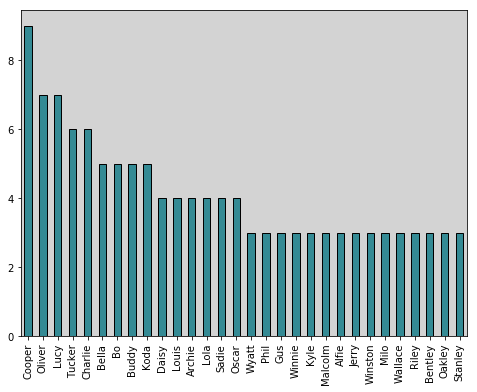

In [156]:
fig, ax = plt.subplots(figsize=(8,6))

names = df_clean['name']
names.value_counts().head(30).plot(kind = 'bar', color = "#348A94", ax = ax, edgecolor = ['Black']*len(names))
ax.set_facecolor('#D3D3D3')
plt.show();

Let's see what the most popular dog types are:

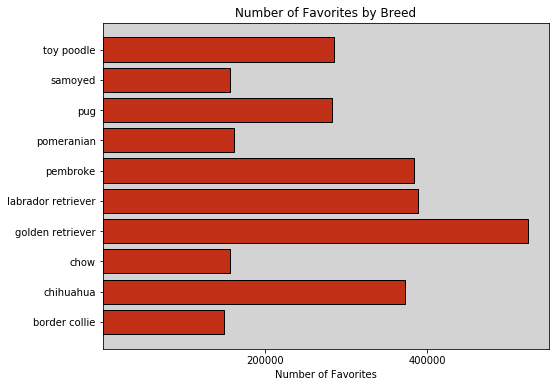

In [157]:
# Creating a favorite dataframe by the groupped breeds, counted the favorites.
df_favorite = df_clean.groupby('predicted_breed')['favorite_count'].sum().reset_index()
df_sorted = df_favorite.sort_values('favorite_count', ascending=False).head(10)
ser_fav = df_sorted['favorite_count']
ser_breed = df_sorted['predicted_breed']

fig, ax = plt.subplots(figsize=(8,6))
fav = plt.barh(ser_breed, ser_fav, color = "#C13016", edgecolor = ['Black']*len(ser_breed))
ax.set_facecolor('#D3D3D3')
plt.xlabel('Number of Favorites')
plt.title('Number of Favorites by Breed')
plt.xticks(np.arange(200000, 600000, 200000))
plt.show();